<a href="https://colab.research.google.com/github/Vimp17/py/blob/main/Word_language_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [8]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [3]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [9]:
sentences = []
word_threshold = 32

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='russian') if len(x) < word_threshold]
        )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 29983


Посчитаем для каждого слова его встречаемость.

In [10]:
words = Counter()


for sentence in sentences:
    word = word_tokenize(sentence, language='russian')  # Токенизация предложения на слова
    words.update(word)

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [11]:
vocab = set()
vocab_size = 40000

special_tokens = ['<unk>', '<bos>', '<eos>', '<pad>']


most_common_words = [word for word, _ in words.items()]


vocab = set(special_tokens + most_common_words)

In [ ]:
len(vocab)

10158

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

AssertionError: 

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 10158


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [12]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [13]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [14]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [15]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [16]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [17]:
def train_model(model, optimizer, criterion, shedu=None, shed=False,num_epoch = 10):
    losses = []
    perplexities = []
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                    logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        if shed:
          shedu.step()

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, train_dataloader))
    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [16]:
class WordLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, dropout: float = 0.1):
        """
        Языковая модель для работы с последовательностью слов.

        Args:
            hidden_dim (int): Размерность скрытого состояния RNN.
            vocab_size (int): Размер словаря (количество уникальных слов).
            embedding_dim (int): Размерность эмбеддингов слов.
            dropout (float): Доля отключаемых нейронов для регуляризации.
        """
        super().__init__()
        # Эмбеддинговый слой для слов
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # RNN (можно заменить GRU на LSTM или другой тип RNN)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # Линейные слои для обработки скрытого состояния
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        # Нелинейная активация и регуляризация
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        """
        Forward pass языковой модели.

        Args:
            input_batch (torch.Tensor): Батч входных индексов слов (размерность [batch_size, seq_len]).

        Returns:
            torch.Tensor: Логиты предсказаний следующего слова (размерность [batch_size, seq_len, vocab_size]).
        """
        # Эмбеддинги слов
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, embedding_dim]
        # RNN слой
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        # Обработка через линейный слой с нелинейностью и dropout
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        # Преобразование в логиты
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection


In [17]:
model = WordLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

loss, per = train_model(model, optimizer, criterion)

Training epoch 0::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/188 [00:00<?, ?it/s]

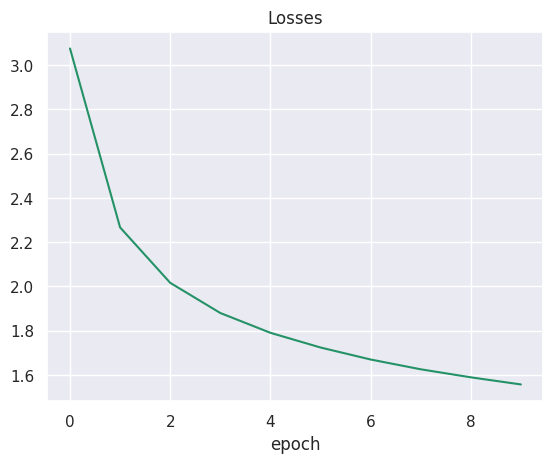

In [18]:
plt.plot(np.arange(len(loss)), loss)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

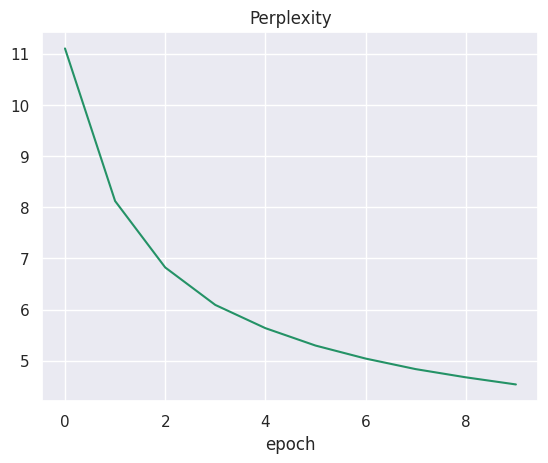

In [19]:
plt.plot(np.arange(len(per)), per)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [18]:
class LSTM_modification_LM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, dropout: float = 0.2):
        """
        Языковая модель для работы с последовательностью слов.

        Args:
            hidden_dim (int): Размерность скрытого состояния LSTM.
            vocab_size (int): Размер словаря (количество уникальных слов).
            dropout (float): Доля отключаемых нейронов для регуляризации.
        """
        super().__init__()
        # Эмбеддинговый слой для слов
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # LSTM с встроенным Dropout
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        # Линейные слои для обработки скрытого состояния
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        # Нелинейная активация и регуляризация
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        """
        Forward pass языковой модели.

        Args:
            input_batch (torch.Tensor): Батч входных индексов слов (размерность [batch_size, seq_len]).

        Returns:
            torch.Tensor: Логиты предсказаний следующего слова (размерность [batch_size, seq_len, vocab_size]).
        """
        # Эмбеддинги слов
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        # LSTM слой
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        # Обработка через линейный слой с нелинейностью и dropout
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        # Преобразование в логиты
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [19]:
model = LSTM_modification_LM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Начальная скорость обучения


loss, per = train_model(model, optimizer, criterion, num_epoch=200)

Training epoch 0::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 30::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 31::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 32::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 33::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 34::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 35::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 36::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 37::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 38::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 39::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 40::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 41::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 42::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 43::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 44::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 45::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 46::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 47::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 48::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 49::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 50::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 51::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 52::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 53::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 54::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 55::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 56::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 57::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 58::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 59::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 60::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 61::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 62::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 63::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 64::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 65::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 66::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 67::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 68::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 69::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 70::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 71::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 72::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 73::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 74::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 75::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 76::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 77::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 78::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 79::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 80::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 81::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 82::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 83::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 84::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 85::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 86::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 87::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 88::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 89::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 90::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 91::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 92::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 93::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 94::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 95::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 96::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 97::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 98::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 99::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 100::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 101::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 102::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 103::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 104::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 105::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 106::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 107::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 108::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 109::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 110::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 111::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 112::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 113::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 114::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 115::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 116::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 117::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 118::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 119::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 120::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 121::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 122::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 123::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 124::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 125::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 126::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 127::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 128::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 129::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 130::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 131::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 132::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 133::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 134::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 135::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 136::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 137::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 138::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 139::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 140::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 141::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 142::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 143::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 144::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 145::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 146::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 147::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 148::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 149::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 150::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 151::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 152::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 153::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 154::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 155::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 156::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 157::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 158::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 159::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 160::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 161::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 162::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 163::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 164::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 165::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 166::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 167::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 168::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 169::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 170::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 171::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 172::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 173::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 174::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 175::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 176::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 177::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 178::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 179::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 180::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 181::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 182::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 183::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 184::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 185::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 186::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 187::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 188::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 189::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 190::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 191::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 192::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 193::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 194::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 195::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 196::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 197::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 198::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 199::   0%|          | 0/188 [00:00<?, ?it/s]

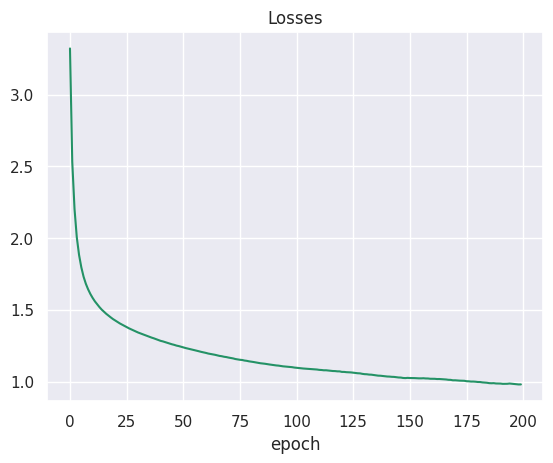

In [20]:
plt.plot(np.arange(len(loss)), loss)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

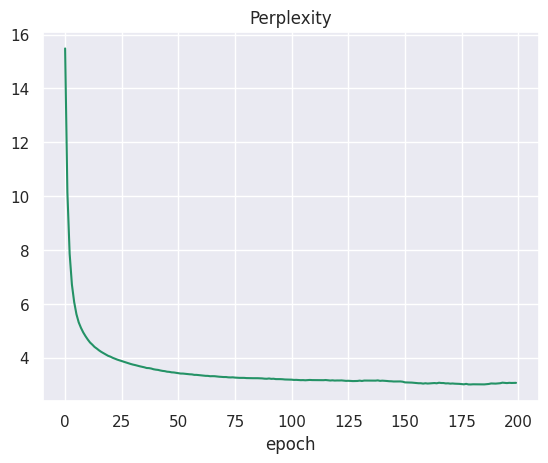

In [21]:
plt.plot(np.arange(len(per)), per)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [26]:
model = LSTM_modification_LM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
from torch.optim.lr_scheduler import StepLR

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Начальная скорость обучения
# Планировщик скорости обучения
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

loss, per = train_model(model, optimizer, criterion, scheduler, True, 20)

Training epoch 0::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/188 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/188 [00:00<?, ?it/s]

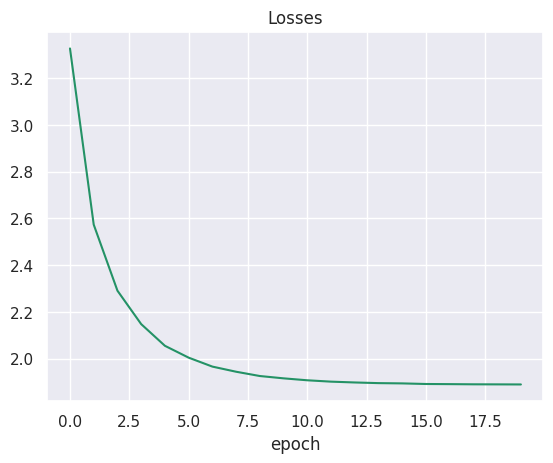

In [27]:
plt.plot(np.arange(len(loss)), loss)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

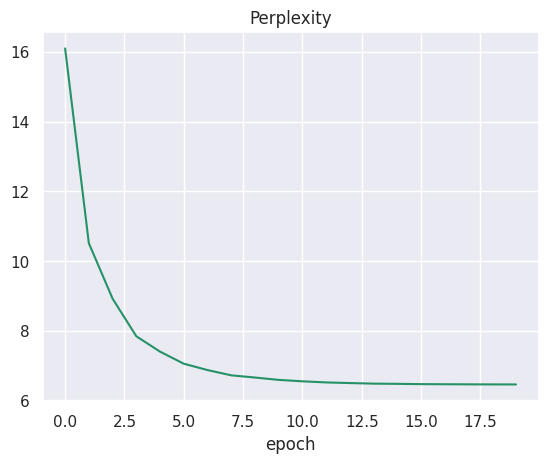

In [28]:
plt.plot(np.arange(len(per)), per)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Модель на основе GRU:

Архитектура: GRU с одним слоем, дропаут после RNN-слоя, линейная проекция на размер словаря.
Оптимизатор: Adam с начальным learning rate 0.001.
Планировщик LR: Не применялся.
Цель: Установить базовую производительность модели.
Модель на основе LSTM:

Архитектура: Заменено GRU на LSTM, остальные параметры идентичны.
Оптимизатор: Adam с начальным learning rate 0.001.
Планировщик LR: Не применялся.
Цель: Сравнить производительность GRU и LSTM.
GRU с адаптацией Learning Rate:

Архитектура: Та же, что и у второй модели.
Оптимизатор: Adam.
Планировщик LR: Использован StepLR с шагом уменьшения каждые 2 эпохи и коэффициентом 0.5.
Цель: Проверить, как адаптация LR влияет на производительность LSTM.

Лучшие результаты у LSTM без планировщика, которая показывает perplexity между 2 и 3
